In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../lib')

pd.set_option('display.max_columns', 500)

from datetime import datetime
from numpy import inf
from math import prod
from IPython.display import clear_output

from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error,mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from scipy.stats import kstest

# Для нейронки
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

# Конфиг
from model_functions import *
from model_features import *
from model_metrics import *

# Для автообновления конфига
%load_ext autoreload
%autoreload 2

### 1. Подготовка

#### Данные

Используем поквартальные данные по тем показателям, которые **прогнозируются Банком РФ и Минэкономразвития**

In [3]:
data=pd.read_excel('../data/data_train.xlsx',sheet_name='data')
descriptions=pd.read_excel('../data/data_train.xlsx',sheet_name='description')

#### Пропуски

In [4]:
drop_feat=[]
for c in data.columns:
    if data[c].isna().sum()>10:
        drop_feat.append(c)
        
data_model=data.drop(drop_feat,axis=1)
print(f'Удалили признаки: {drop_feat}')

Удалили признаки: ['vi_mining', 'vi_industry']


#### Лишние признаки

Удалим сальдовые признаки

In [5]:
saldo_feat=[c for c in data_model.columns if 'saldo' in c]
data_model=data_model.drop(saldo_feat,axis=1)
print(f'Удалили признаки: {saldo_feat}')

Удалили признаки: ['saldo_stp_sok', 'saldo_fin']


#### Классификация признаков

Делим признаки на три группы:
1. Процентные признаки (для них ничего делать не будем);
2. Индексные признаки (их приведём к приростам, отняв 100%);
3. Количественные признаки (для них рассчитаем приросты).

In [6]:
percent_features=['unempl_rate','int_rate']
index_features=['cpi','vi_mining','vi_industry']
count_features=[x for x in data_model.drop('period',axis=1) if x not in (percent_features+index_features)]

### 2. Генерация признаков

Все признаки и таргет приведём к темпам прироста по следующим причинам:
1. Всё будет в одном масштабе, что хорошо для линейной регрессии (она не очень терпит диспропорции в размерах данных);
2. Сохраняется интерпретация (если для унификации масштаба делать нормализацию/стандартизацию, то теряется интерпретируемость);
3. Банк РФ/Минэкономразвития тоже прогнозирует в приростах.

Затем добавим 1-е лаги признаков

#### Темпы прироста

In [7]:
data_delta=pd.DataFrame()
# Сдвигаем период на 1 вперёд
data_delta['period']=data_model['period'][1:]
# Добавляем темпы прироста
for c in data_model.drop('period',axis=1).columns:
    if c in count_features:
        data_delta[c]=(data_model[c][1:].values/data_model[c][0:-1].values-1)*100
    elif c in index_features:
        data_delta[c]=data_model[c]-100
    else:
        data_delta[c]=data_model[c]

#### Лаги

In [8]:
data_lag=pd.DataFrame()
# Сдвигаем период на 1 вперёд относительно data_delta
data_lag['period']=data_delta['period'][1:]
# Добавляем лаги
for c in data_delta.drop('period',axis=1).columns:
    data_lag[f'l1_{c}']=data_delta[c][:-1].values

#### Объединяем

In [9]:
dataset=pd.merge(data_lag,data_delta,on='period').drop(['debt_rub','l1_debt_rub'],axis=1)
# Список признаков
feature_list=dataset.drop(['period','target'],axis=1).columns
target='target'
print(f'Число наблюдений: {len(dataset)}, число признаков: {len(feature_list)}')

Число наблюдений: 54, число признаков: 29


#### Обработаем Nan и inf

In [10]:
# Обрабатываем пропуски
dataset_lr=dataset.dropna()
# Обрабатываем inf
dataset_lr.replace([np.inf, -np.inf], 0, inplace=True)
# Выводим информацию
print(f'Число наблюдений после удаления пропусков: {len(dataset_lr)}')
print(f'Начальный период: {dataset_lr["period"].min()}')
print(f'Конечный период: {dataset_lr["period"].max()}')

Число наблюдений после удаления пропусков: 46
Начальный период: 2011-04-01 00:00:00
Конечный период: 2022-07-01 00:00:00


### 3. Нейросеть без "чёрных лебедей"

#### Датафреймы для заполнения

In [23]:
# Текущая дата
date_now=datetime.now()
# Квартальные прогнозы
try:
    quarter_predictions=pd.read_excel('Квартальные прогнозы.xlsx')
except:
    quarter_predictions=pd.DataFrame({'period':dataset_lr.period}).reset_index().drop('index',axis=1)
    quarter_predictions['y_true']=dataset_lr['target'].reset_index().drop('index',axis=1)
# Годовые прогнозы
try:
    year_predictions=pd.read_excel('Годовые прогнозы.xlsx')
except:
    year_predictions=pd.DataFrame({'year': range(2011,2023)})
# Метрики
try:
    metric_df=pd.read_excel('Метрики по годам.xlsx')
except:
    metric_df=pd.DataFrame(columns=['Модель','MAE','MAPE','MedianAE','MedianAPE','updated_dt'])

#### На всех признаках

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.03,2.04,67.00
MSE,0.00,6.00,inf
MAPE,1.73,25.48,13.73


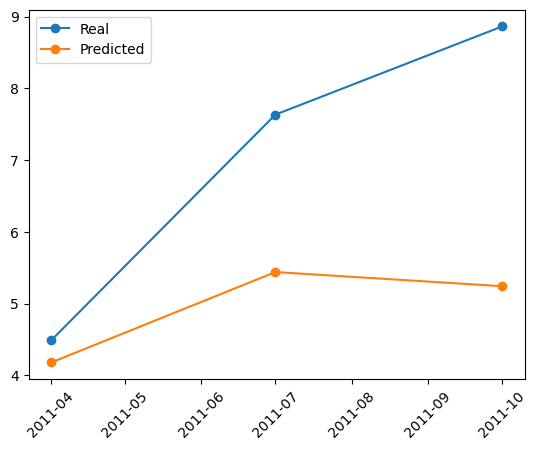

Реальный прирост за 2011 год: 22.43%
Прогнозный прирост за 2011 год: 15.61%

1/1 [==============================] - 0s 18ms/step


,Train,Test,Relative Difference
MAE,0.02,2.61,129.50
MSE,0.00,9.13,inf
MAPE,1.18,35.51,29.09


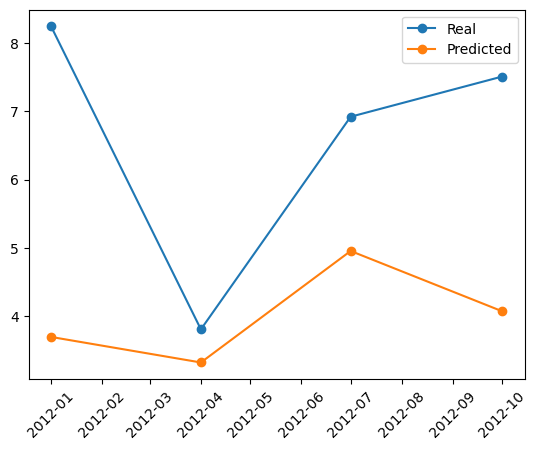

Реальный прирост за 2012 год: 29.15%
Прогнозный прирост за 2012 год: 17.03%

1/1 [==============================] - 0s 18ms/step


,Train,Test,Relative Difference
MAE,0.02,0.90,44.00
MSE,0.00,1.16,inf
MAPE,1.75,18.25,9.43


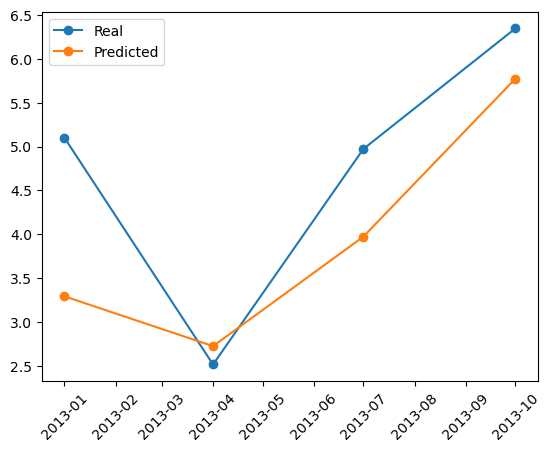

Реальный прирост за 2013 год: 20.28%
Прогнозный прирост за 2013 год: 16.68%

1/1 [==============================] - 0s 18ms/step


,Train,Test,Relative Difference
MAE,0.02,1.30,64.0
MSE,0.00,3.60,inf
MAPE,1.05,38.53,35.7


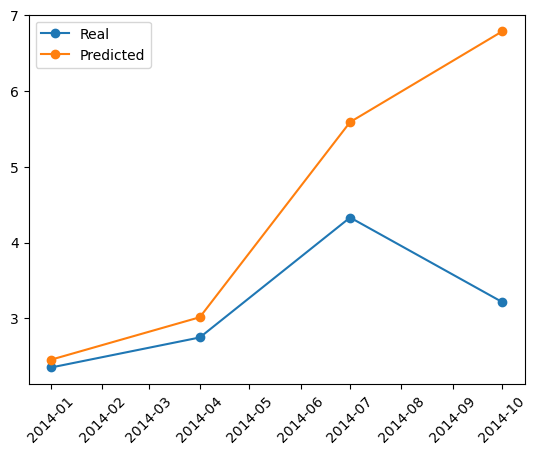

Реальный прирост за 2014 год: 13.25%
Прогнозный прирост за 2014 год: 19.0%

1/1 [==============================] - 0s 19ms/step


,Train,Test,Relative Difference
MAE,0.02,2.86,142.0
MSE,0.00,10.89,inf
MAPE,1.52,252.78,165.3


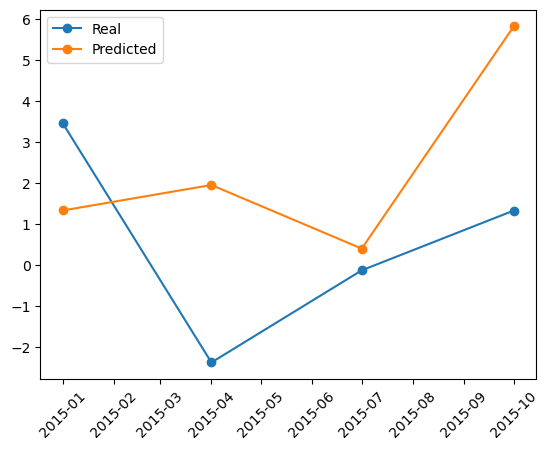

Реальный прирост за 2015 год: 2.23%
Прогнозный прирост за 2015 год: 9.77%

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.04,1.51,36.75
MSE,0.00,3.78,inf
MAPE,1.54,727.32,471.29


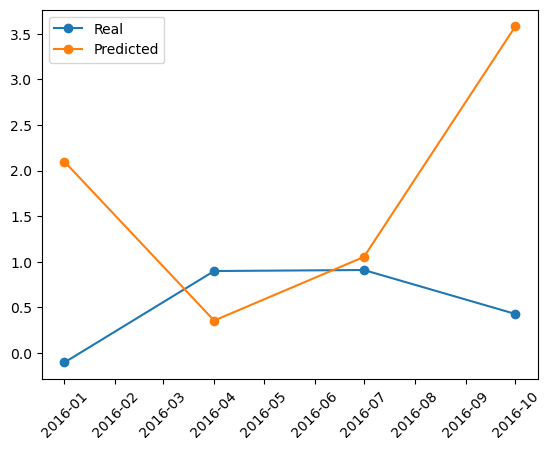

Реальный прирост за 2016 год: 2.14%
Прогнозный прирост за 2016 год: 7.25%

1/1 [==============================] - 0s 18ms/step


,Train,Test,Relative Difference
MAE,0.02,1.87,92.50
MSE,0.00,4.69,inf
MAPE,1.55,135.15,86.19


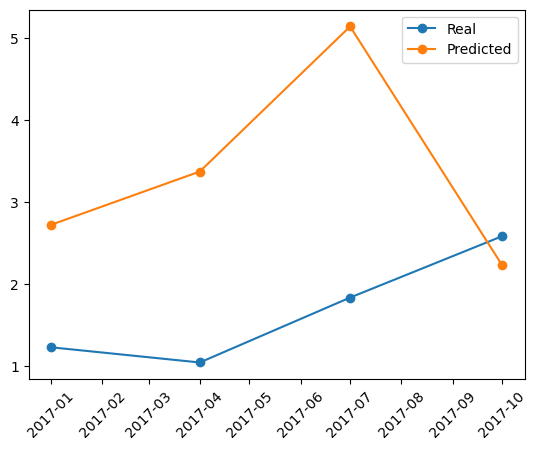

Реальный прирост за 2017 год: 6.84%
Прогнозный прирост за 2017 год: 14.13%

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.02,1.05,51.50
MSE,0.00,1.89,inf
MAPE,1.09,27.23,23.98


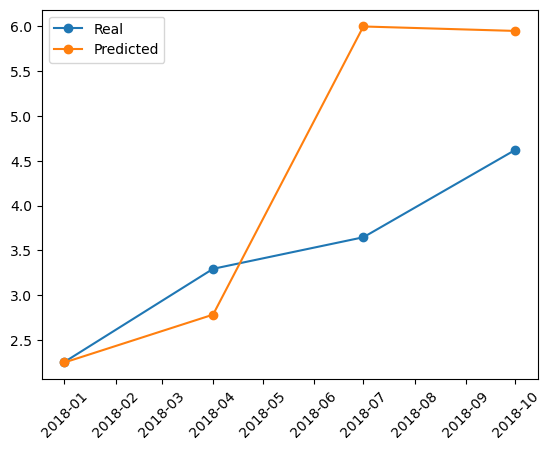

Реальный прирост за 2018 год: 14.54%
Прогнозный прирост за 2018 год: 18.03%

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.03,0.92,29.67
MSE,0.00,1.47,inf
MAPE,1.36,29.63,20.79


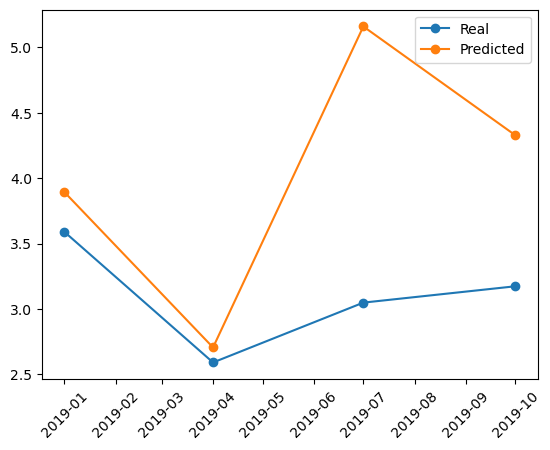

Реальный прирост за 2019 год: 12.99%
Прогнозный прирост за 2019 год: 17.07%

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.03,1.91,62.67
MSE,0.00,4.23,inf
MAPE,1.85,86.49,45.75


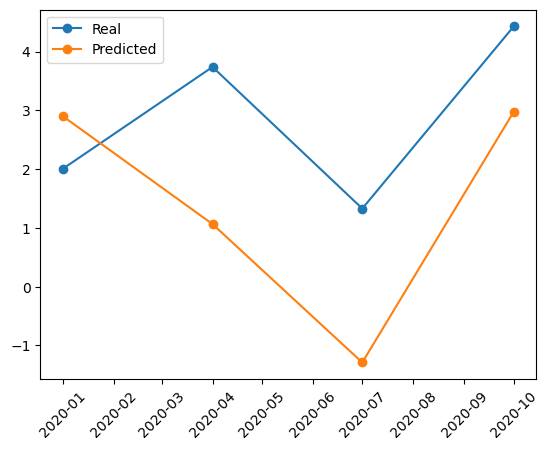

Реальный прирост за 2020 год: 11.97%
Прогнозный прирост за 2020 год: 5.71%

1/1 [==============================] - 0s 18ms/step


,Train,Test,Relative Difference
MAE,0.03,1.04,33.67
MSE,0.00,2.15,inf
MAPE,1.87,44.35,22.72


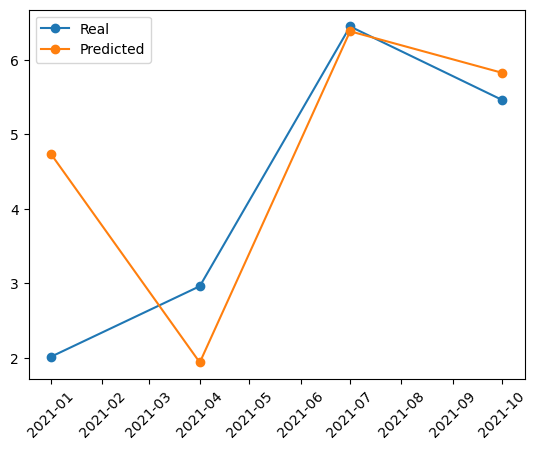

Реальный прирост за 2021 год: 17.92%
Прогнозный прирост за 2021 год: 20.2%

1/1 [==============================] - 0s 18ms/step


,Train,Test,Relative Difference
MAE,0.02,1.53,75.50
MSE,0.00,2.85,inf
MAPE,1.03,48.79,46.37


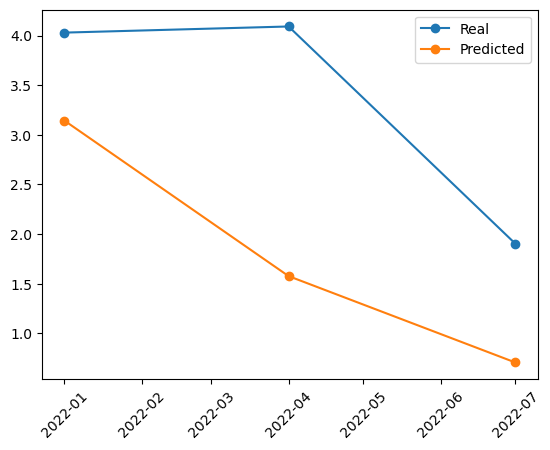

Реальный прирост за 2022 год: 10.35%
Прогнозный прирост за 2022 год: 5.51%

---------------------------------------------------------------------------
Средняя абсолютная ошибка по годовых прогнозам: 5.76%
Средняя относительная ошибка по годовых прогнозам: 81.95%
---------------------------------------------------------------------------
Медианная абсолютная ошибка по годовых прогнозам: 5.43%
Медианная относительная ошибка по годовых прогнозам: 42.52%
---------------------------------------------------------------------------


In [12]:
# Списки для заполнения
y_test_year_list=[]
y_test_pred_year_list=[]
quarter_pred_list=[]
# Прогоняем
for year in range(2011,2023):
    ## Выделяем train/test
    data_train=dataset_lr[(dataset_lr.period<f'{year}-01-01')|(dataset_lr.period>=f'{year}-12-31')]
    data_test=dataset_lr[(dataset_lr.period>=f'{year}-01-01')&(dataset_lr.period<f'{year}-12-31')]
    ## Выделяем X_train, X_test, y_train, y_test
    trainX, trainY = data_train[feature_list], data_train['target']
    testX, testY =  data_test[feature_list], data_test['target']
    trainX = np.reshape(trainX.values, (trainX.shape[0], 1,trainX.shape[1]))
    testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))
    ## Строим модель
    model = Sequential()
    model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2] )))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    history = model.fit(trainX, trainY, epochs=300, batch_size=8, validation_data=(testX, testY), verbose=0, shuffle=False)
    ## Строим прогнозы
    y_train_pred=model.predict(trainX)
    y_test_pred=model.predict(testX)
    ## Добавляем для отчёта
    for pred in y_test_pred:
        quarter_pred_list.append(pred[0])
    ## Смотрим качество
    display(regression_report(trainY,y_train_pred,testY,y_test_pred))
    ## Строим графики
    plt.plot(data_test.period,testY, label='Real',marker='o')
    plt.plot(data_test.period,y_test_pred, label='Predicted',marker='o')
    plt.xticks(rotation = 45)
    plt.legend()
    plt.show()
    ## Агрегируем реальные и прогнозные значения
    y_test_year=prod(100+testY)/(100**(len(testY)-1))
    y_test_pred_year=prod(100+y_test_pred)/(100**(len(y_test_pred)-1))
    ## Добавляем в списки
    y_test_year_list.append(y_test_year-100)
    y_test_pred_year_list.append(y_test_pred_year[0]-100)
    ## Выводим
    print(f'Реальный прирост за {year} год: {round((y_test_year-100),2)}%')
    print(f'Прогнозный прирост за {year} год: {round((y_test_pred_year[0]-100),2)}%\n')
# Считаем метрики
mae=round(mean_absolute_error(y_test_year_list,y_test_pred_year_list),2)
mape=round(mean_absolute_percentage_error(y_test_year_list,y_test_pred_year_list)*100,2)
medianae=round(median_absolute_error(y_test_year_list,y_test_pred_year_list),2)
medianape=round(median_absolute_percentage_error(y_test_year_list,y_test_pred_year_list)*100,2)
# Итог
print('---------------------------------------------------------------------------')
print(f'Средняя абсолютная ошибка по годовых прогнозам: {mae}%')
print(f'Средняя относительная ошибка по годовых прогнозам: {mape}%')
print('---------------------------------------------------------------------------')
print(f'Медианная абсолютная ошибка по годовых прогнозам: {medianae}%')
print(f'Медианная относительная ошибка по годовых прогнозам: {medianape}%')
print('---------------------------------------------------------------------------')
# Формируем отчёт
metric_df.loc[len(metric_df)] = ['Нейросеть без отбора признаков и дамми-переменных',
                                 mae,mape,medianae,medianape,date_now]
year_predictions['y_true']=y_test_year_list
year_predictions['y_pred_nn_full_nodummy']=y_test_pred_year_list
quarter_predictions['y_pred_nn_full_nodummy']=quarter_pred_list

#### На отобранных признаках

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.03,1.36,44.33
MSE,0.00,2.76,inf
MAPE,3.24,19.81,5.11


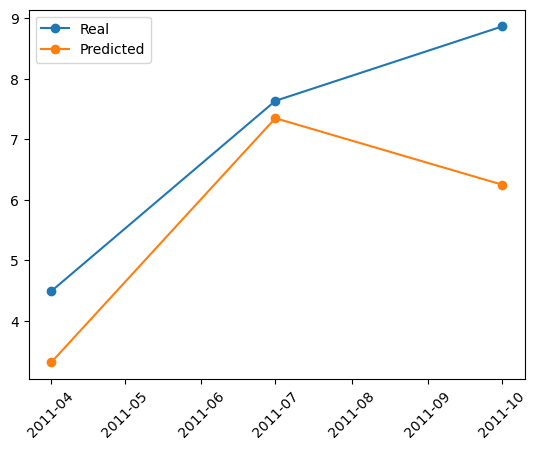

Реальный прирост за 2011 год: 22.43%
Прогнозный прирост за 2011 год: 17.83%

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.05,1.25,24.00
MSE,0.00,2.40,inf
MAPE,3.70,19.82,4.36


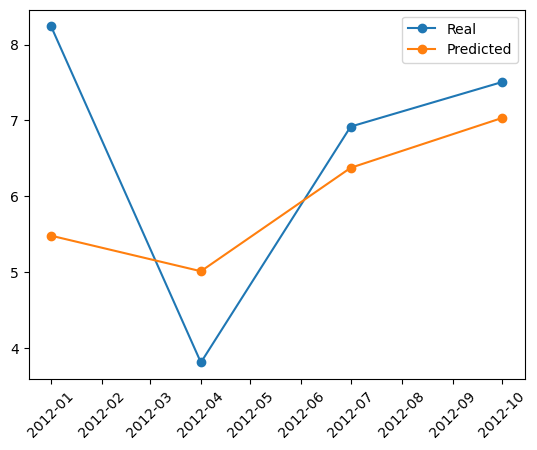

Реальный прирост за 2012 год: 29.15%
Прогнозный прирост за 2012 год: 26.11%

1/1 [==============================] - 0s 18ms/step


,Train,Test,Relative Difference
MAE,0.05,1.00,19.00
MSE,0.00,1.43,inf
MAPE,4.97,21.77,3.38


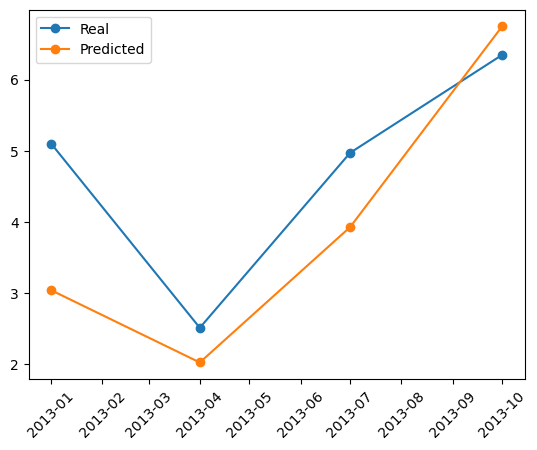

Реальный прирост за 2013 год: 20.28%
Прогнозный прирост за 2013 год: 16.63%

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.05,1.21,23.20
MSE,0.00,2.06,inf
MAPE,2.08,42.83,19.59


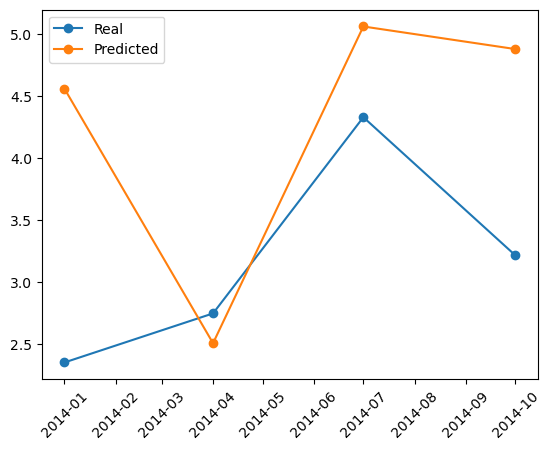

Реальный прирост за 2014 год: 13.25%
Прогнозный прирост за 2014 год: 18.1%

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.05,1.51,29.20
MSE,0.00,3.25,inf
MAPE,2.46,190.38,76.39


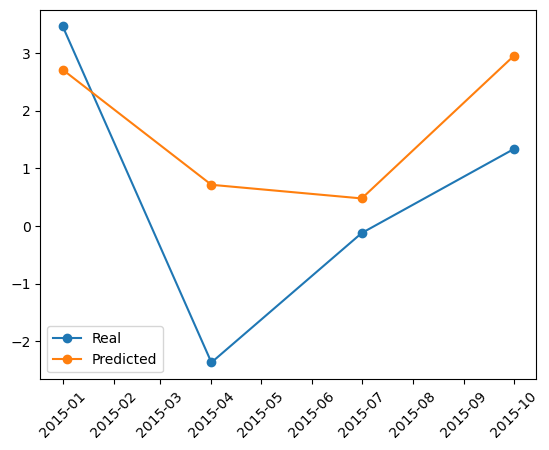

Реальный прирост за 2015 год: 2.23%
Прогнозный прирост за 2015 год: 6.99%

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.07,1.25,16.86
MSE,0.01,2.27,226.00
MAPE,2.84,665.32,233.27


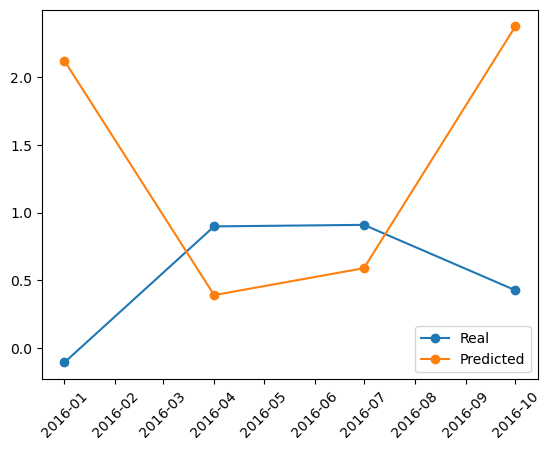

Реальный прирост за 2016 год: 2.14%
Прогнозный прирост за 2016 год: 5.57%

1/1 [==============================] - 0s 18ms/step


,Train,Test,Relative Difference
MAE,0.04,0.84,20.00
MSE,0.00,0.93,inf
MAPE,4.21,57.42,12.64


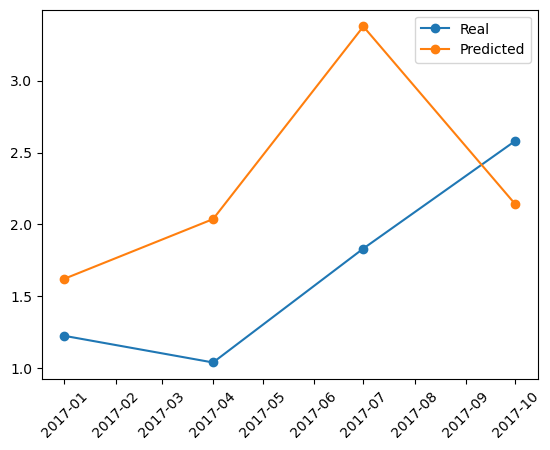

Реальный прирост за 2017 год: 6.84%
Прогнозный прирост за 2017 год: 9.49%

1/1 [==============================] - 0s 18ms/step


,Train,Test,Relative Difference
MAE,0.05,1.55,30.00
MSE,0.00,4.54,inf
MAPE,2.81,44.21,14.73


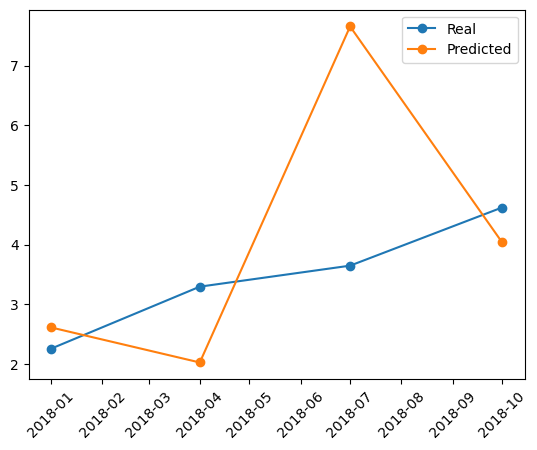

Реальный прирост за 2018 год: 14.54%
Прогнозный прирост за 2018 год: 17.26%

1/1 [==============================] - 0s 18ms/step


,Train,Test,Relative Difference
MAE,0.04,0.42,9.50
MSE,0.00,0.21,inf
MAPE,2.89,14.49,4.01


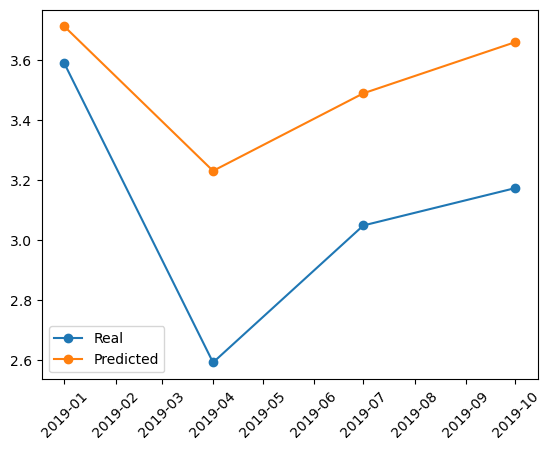

Реальный прирост за 2019 год: 12.99%
Прогнозный прирост за 2019 год: 14.86%

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.05,1.41,27.20
MSE,0.00,2.35,inf
MAPE,2.55,61.53,23.13


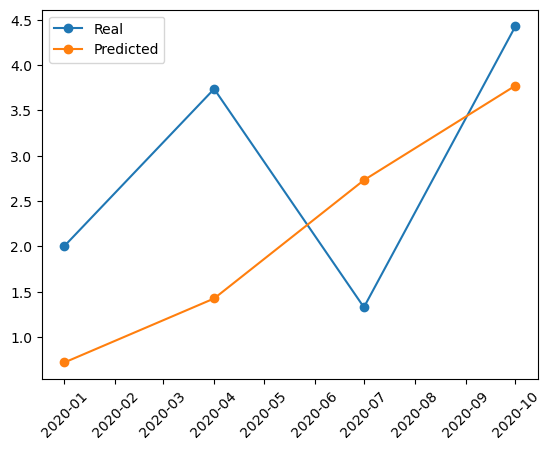

Реальный прирост за 2020 год: 11.97%
Прогнозный прирост за 2020 год: 8.91%

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.04,0.69,16.25
MSE,0.00,0.71,inf
MAPE,3.22,15.95,3.95


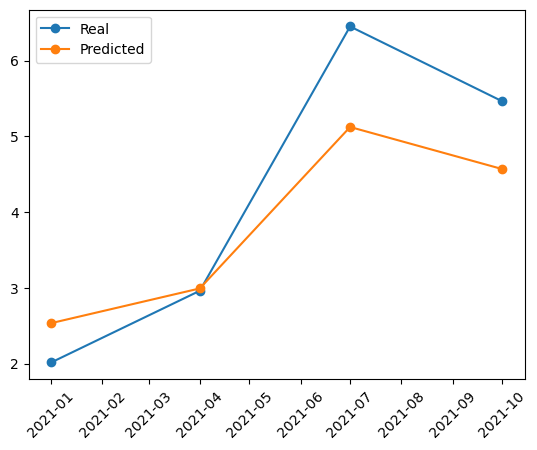

Реальный прирост за 2021 год: 17.92%
Прогнозный прирост за 2021 год: 16.08%

1/1 [==============================] - 0s 18ms/step


,Train,Test,Relative Difference
MAE,0.03,1.56,51.00
MSE,0.00,2.46,inf
MAPE,2.33,50.74,20.78


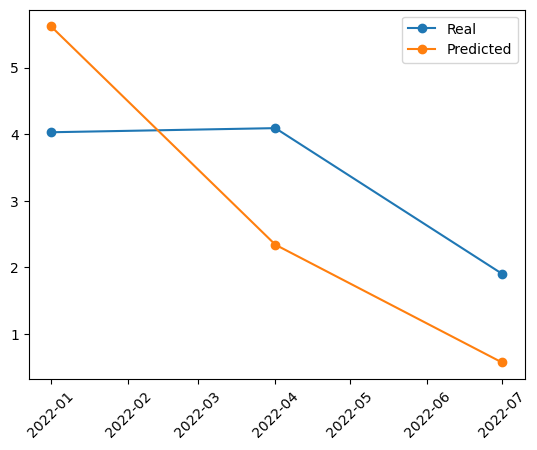

Реальный прирост за 2022 год: 10.35%
Прогнозный прирост за 2022 год: 8.71%

---------------------------------------------------------------------------
Средняя абсолютная ошибка по годовых прогнозам: 3.18%
Средняя относительная ошибка по годовых прогнозам: 48.57%
---------------------------------------------------------------------------
Медианная абсолютная ошибка по годовых прогнозам: 3.05%
Медианная относительная ошибка по годовых прогнозам: 19.6%
---------------------------------------------------------------------------


In [13]:
# Список признаков
feature_list_selected=['l1_target', 
                       'l1_rkpdh_volume', 
                        'gdp_volume', 
                        'l1_int_rate', 
                        'urals_price', 
                        'wages', 
                        'l1_ex_volume', 
                        'unempl_rate']
# Списки для заполнения
y_test_year_list=[]
y_test_pred_year_list=[]
quarter_pred_list=[]
# Прогоняем
for year in range(2011,2023):
    ## Выделяем train/test
    data_train=dataset_lr[(dataset_lr.period<f'{year}-01-01')|(dataset_lr.period>=f'{year}-12-31')]
    data_test=dataset_lr[(dataset_lr.period>=f'{year}-01-01')&(dataset_lr.period<f'{year}-12-31')]
    ## Выделяем X_train, X_test, y_train, y_test
    trainX, trainY = data_train[feature_list_selected], data_train['target']
    testX, testY =  data_test[feature_list_selected], data_test['target']
    trainX = np.reshape(trainX.values, (trainX.shape[0], 1,trainX.shape[1]))
    testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))
    ## Строим модель
    model = Sequential()
    model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2] )))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    history = model.fit(trainX, trainY, epochs=300, batch_size=8, validation_data=(testX, testY), verbose=0, shuffle=False)
    ## Строим прогнозы
    y_train_pred=model.predict(trainX)
    y_test_pred=model.predict(testX)
    ## Добавляем для отчёта
    for pred in y_test_pred:
        quarter_pred_list.append(pred[0])
    ## Смотрим качество
    display(regression_report(trainY,y_train_pred,testY,y_test_pred))
    ## Строим графики
    plt.plot(data_test.period,testY, label='Real',marker='o')
    plt.plot(data_test.period,y_test_pred, label='Predicted',marker='o')
    plt.xticks(rotation = 45)
    plt.legend()
    plt.show()
    ## Агрегируем реальные и прогнозные значения
    y_test_year=prod(100+testY)/(100**(len(testY)-1))
    y_test_pred_year=prod(100+y_test_pred)/(100**(len(y_test_pred)-1))
    ## Добавляем в списки
    y_test_year_list.append(y_test_year-100)
    y_test_pred_year_list.append(y_test_pred_year[0]-100)
    ## Выводим
    print(f'Реальный прирост за {year} год: {round((y_test_year-100),2)}%')
    print(f'Прогнозный прирост за {year} год: {round((y_test_pred_year[0]-100),2)}%\n')
# Считаем метрики
mae=round(mean_absolute_error(y_test_year_list,y_test_pred_year_list),2)
mape=round(mean_absolute_percentage_error(y_test_year_list,y_test_pred_year_list)*100,2)
medianae=round(median_absolute_error(y_test_year_list,y_test_pred_year_list),2)
medianape=round(median_absolute_percentage_error(y_test_year_list,y_test_pred_year_list)*100,2)
# Итог
print('---------------------------------------------------------------------------')
print(f'Средняя абсолютная ошибка по годовых прогнозам: {mae}%')
print(f'Средняя относительная ошибка по годовых прогнозам: {mape}%')
print('---------------------------------------------------------------------------')
print(f'Медианная абсолютная ошибка по годовых прогнозам: {medianae}%')
print(f'Медианная относительная ошибка по годовых прогнозам: {medianape}%')
print('---------------------------------------------------------------------------')
# Формируем отчёт
metric_df.loc[len(metric_df)] = ['Нейросеть после отбора признаков без дамми-переменных',
                                 mae,mape,medianae,medianape,date_now]
year_predictions['y_pred_nn_selected_nodummy']=y_test_pred_year_list
quarter_predictions['y_pred_nn_selected_nodummy']=quarter_pred_list

### 4. Нейросеть с "чёрными лебедями"

#### Добавляем дамми-переменные

In [14]:
# Суетные периоды
period_list=['2020-04-01','2022-04-01']
period_list_l1=['2020-01-01','2022-01-01']
period_list_dotacii=['2020-07-01','2021-01-01',]
period_list_dotacii_l1=['2020-04-01','2020-10-01'] 
# Дамми-переменные
dataset_lr['black_swan']=np.where(dataset_lr['period'].isin(period_list),1,0)
dataset_lr['l1_black_swan']=np.where(dataset_lr['period'].isin(period_list_l1),1,0)
dataset_lr['dotacii']=np.where(dataset_lr['period'].isin(period_list_dotacii),1,0)
dataset_lr['l1_dotacii']=np.where(dataset_lr['period'].isin(period_list_dotacii_l1),1,0)

#### На всех признаках

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.03,2.44,80.33
MSE,0.00,7.65,inf
MAPE,1.79,32.47,17.14


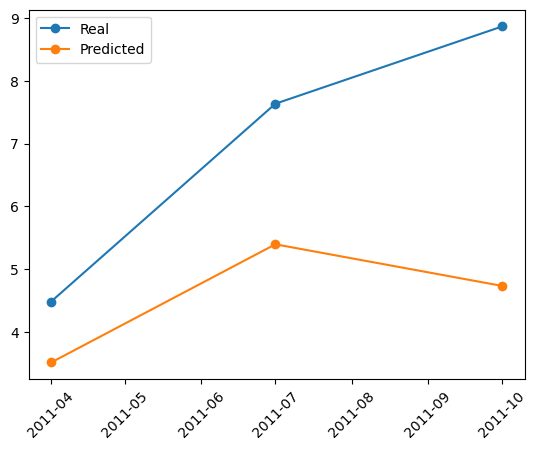

Реальный прирост за 2011 год: 22.43%
Прогнозный прирост за 2011 год: 14.28%

1/1 [==============================] - 0s 18ms/step


,Train,Test,Relative Difference
MAE,0.02,2.74,136.0
MSE,0.00,9.64,inf
MAPE,2.66,38.57,13.5


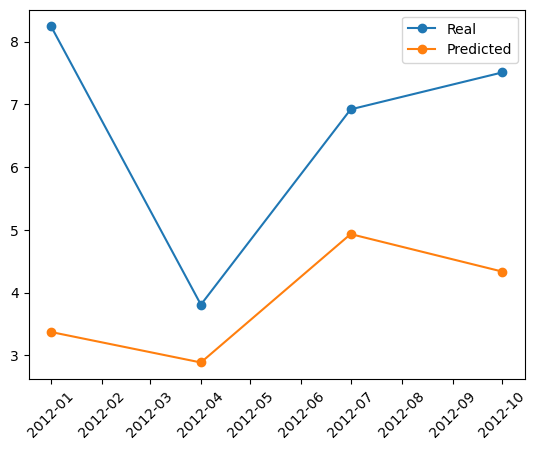

Реальный прирост за 2012 год: 29.15%
Прогнозный прирост за 2012 год: 16.44%

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.02,1.13,55.50
MSE,0.00,1.83,inf
MAPE,2.11,24.63,10.67


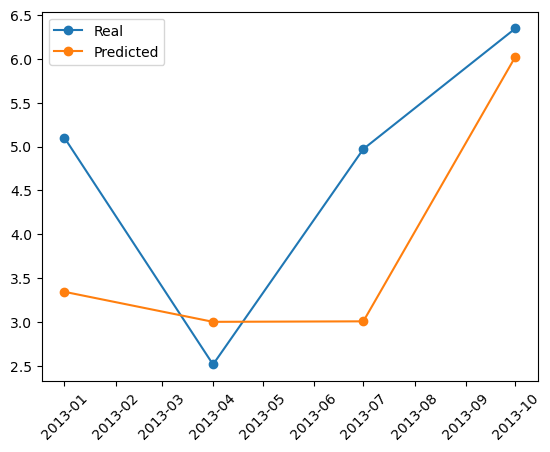

Реальный прирост за 2013 год: 20.28%
Прогнозный прирост за 2013 год: 16.24%

1/1 [==============================] - 0s 18ms/step


,Train,Test,Relative Difference
MAE,0.02,1.52,75.00
MSE,0.00,3.49,inf
MAPE,1.68,48.28,27.74


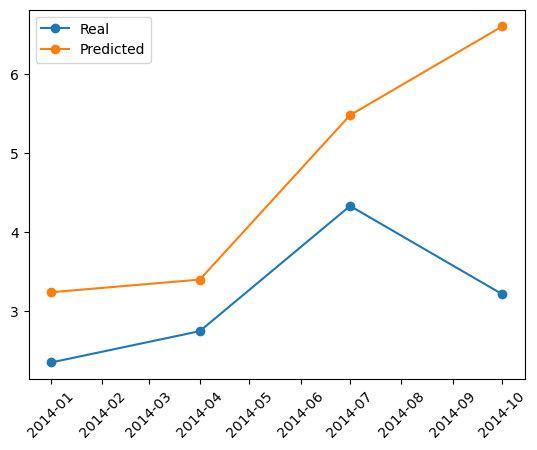

Реальный прирост за 2014 год: 13.25%
Прогнозный прирост за 2014 год: 20.02%

1/1 [==============================] - 0s 18ms/step


,Train,Test,Relative Difference
MAE,0.04,2.89,71.25
MSE,0.00,10.89,inf
MAPE,1.72,212.78,122.71


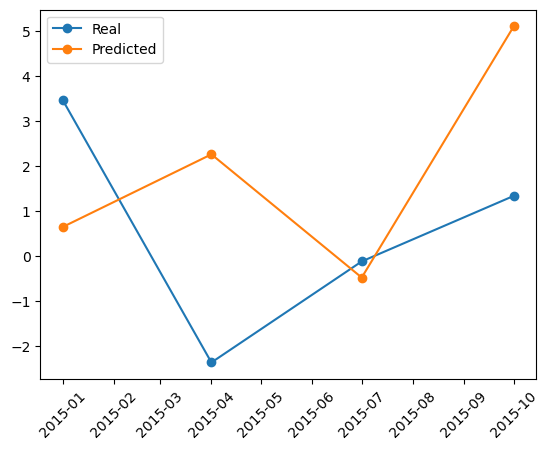

Реальный прирост за 2015 год: 2.23%
Прогнозный прирост за 2015 год: 7.63%

1/1 [==============================] - 0s 18ms/step


,Train,Test,Relative Difference
MAE,0.02,1.82,90.00
MSE,0.00,5.27,inf
MAPE,0.82,844.77,1029.21


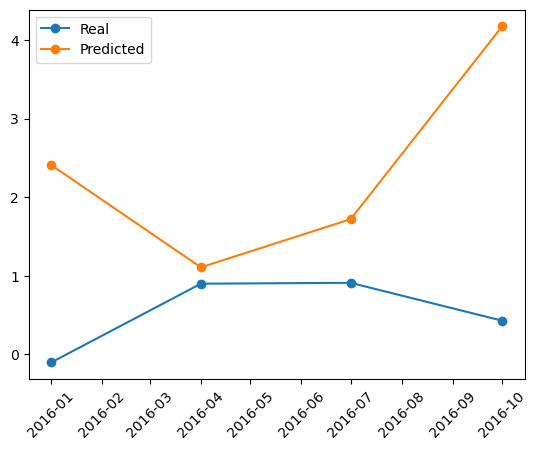

Реальный прирост за 2016 год: 2.14%
Прогнозный прирост за 2016 год: 9.72%

1/1 [==============================] - 0s 18ms/step


,Train,Test,Relative Difference
MAE,0.02,1.66,82.00
MSE,0.00,3.27,inf
MAPE,1.08,124.32,114.11


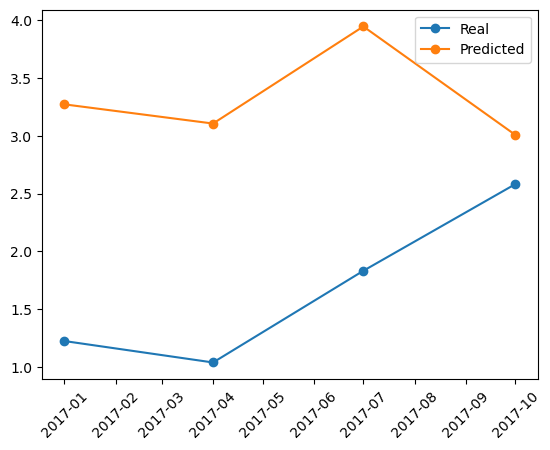

Реальный прирост за 2017 год: 6.84%
Прогнозный прирост за 2017 год: 14.0%

1/1 [==============================] - 0s 18ms/step


,Train,Test,Relative Difference
MAE,0.04,1.31,31.75
MSE,0.00,2.07,inf
MAPE,1.78,37.64,20.15


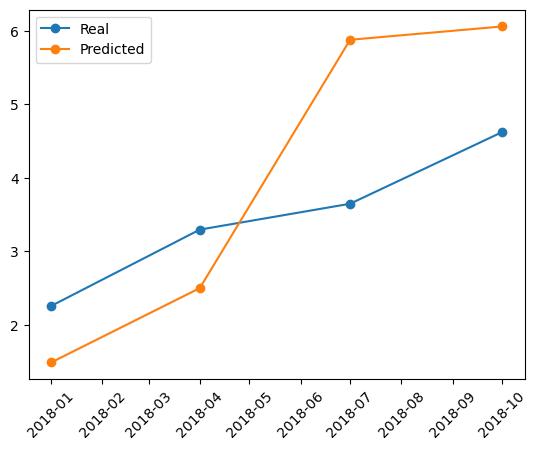

Реальный прирост за 2018 год: 14.54%
Прогнозный прирост за 2018 год: 16.81%

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.02,0.99,48.50
MSE,0.00,1.43,inf
MAPE,0.97,32.47,32.47


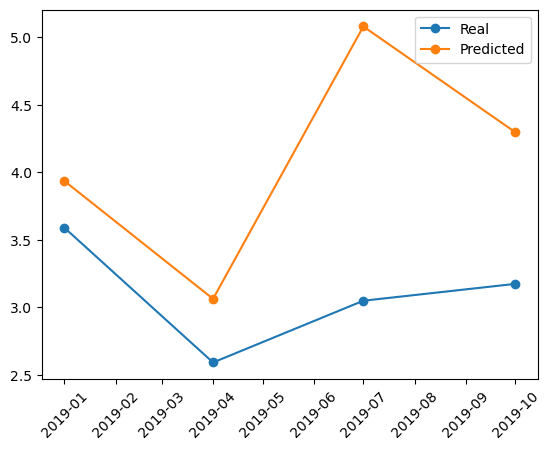

Реальный прирост за 2019 год: 12.99%
Прогнозный прирост за 2019 год: 17.4%

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.03,2.37,78.00
MSE,0.00,5.76,inf
MAPE,2.05,98.24,46.92


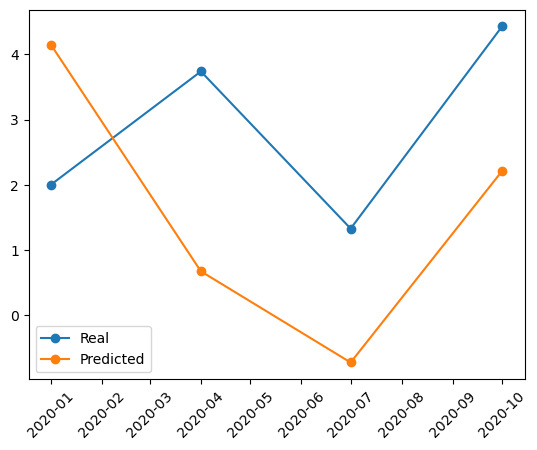

Реальный прирост за 2020 год: 11.97%
Прогнозный прирост за 2020 год: 6.39%

1/1 [==============================] - 0s 18ms/step


,Train,Test,Relative Difference
MAE,0.02,0.78,38.00
MSE,0.00,1.49,inf
MAPE,1.23,34.03,26.67


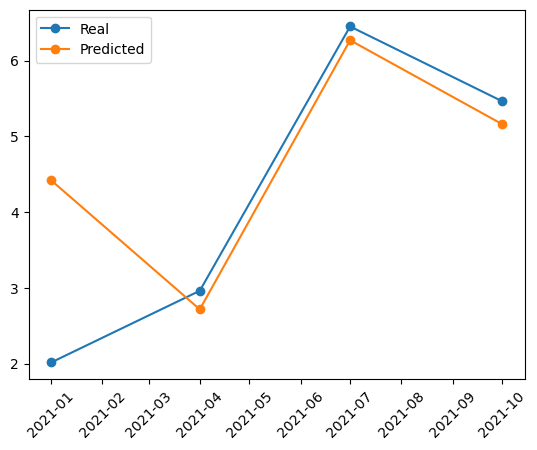

Реальный прирост за 2021 год: 17.92%
Прогнозный прирост за 2021 год: 19.86%

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.03,2.22,73.00
MSE,0.00,5.51,inf
MAPE,1.80,84.02,45.68


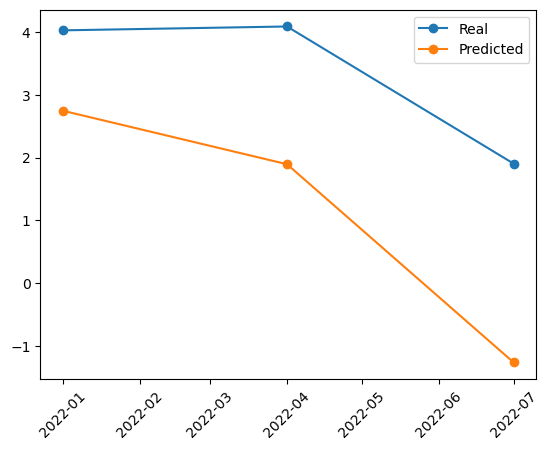

Реальный прирост за 2022 год: 10.35%
Прогнозный прирост за 2022 год: 3.37%

---------------------------------------------------------------------------
Средняя абсолютная ошибка по годовых прогнозам: 6.08%
Средняя относительная ошибка по годовых прогнозам: 85.52%
---------------------------------------------------------------------------
Медианная абсолютная ошибка по годовых прогнозам: 6.18%
Медианная относительная ошибка по годовых прогнозам: 45.12%
---------------------------------------------------------------------------


In [15]:
# Списки для заполнения
y_test_year_list=[]
y_test_pred_year_list=[]
quarter_pred_list=[]
# Прогоняем
for year in range(2011,2023):
    ## Выделяем train/test
    data_train=dataset_lr[(dataset_lr.period<f'{year}-01-01')|(dataset_lr.period>=f'{year}-12-31')]
    data_test=dataset_lr[(dataset_lr.period>=f'{year}-01-01')&(dataset_lr.period<f'{year}-12-31')]
    ## Выделяем X_train, X_test, y_train, y_test
    trainX, trainY = data_train.drop(['period','target'],axis=1), data_train['target']
    testX, testY =  data_test.drop(['period','target'],axis=1), data_test['target']
    trainX = np.reshape(trainX.values, (trainX.shape[0], 1,trainX.shape[1]))
    testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))
    ## Строим модель
    model = Sequential()
    model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2] )))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    history = model.fit(trainX, trainY, epochs=300, batch_size=8, validation_data=(testX, testY), verbose=0, shuffle=False)
    ## Строим прогнозы
    y_train_pred=model.predict(trainX)
    y_test_pred=model.predict(testX)
    ## Добавляем для отчёта
    for pred in y_test_pred:
        quarter_pred_list.append(pred[0])
    ## Смотрим качество
    display(regression_report(trainY,y_train_pred,testY,y_test_pred))
    ## Строим графики
    plt.plot(data_test.period,testY, label='Real',marker='o')
    plt.plot(data_test.period,y_test_pred, label='Predicted',marker='o')
    plt.xticks(rotation = 45)
    plt.legend()
    plt.show()
    ## Агрегируем реальные и прогнозные значения
    y_test_year=prod(100+testY)/(100**(len(testY)-1))
    y_test_pred_year=prod(100+y_test_pred)/(100**(len(y_test_pred)-1))
    ## Добавляем в списки
    y_test_year_list.append(y_test_year-100)
    y_test_pred_year_list.append(y_test_pred_year[0]-100)
    ## Выводим
    print(f'Реальный прирост за {year} год: {round((y_test_year-100),2)}%')
    print(f'Прогнозный прирост за {year} год: {round((y_test_pred_year[0]-100),2)}%\n')
# Считаем метрики
mae=round(mean_absolute_error(y_test_year_list,y_test_pred_year_list),2)
mape=round(mean_absolute_percentage_error(y_test_year_list,y_test_pred_year_list)*100,2)
medianae=round(median_absolute_error(y_test_year_list,y_test_pred_year_list),2)
medianape=round(median_absolute_percentage_error(y_test_year_list,y_test_pred_year_list)*100,2)
# Итог
print('---------------------------------------------------------------------------')
print(f'Средняя абсолютная ошибка по годовых прогнозам: {mae}%')
print(f'Средняя относительная ошибка по годовых прогнозам: {mape}%')
print('---------------------------------------------------------------------------')
print(f'Медианная абсолютная ошибка по годовых прогнозам: {medianae}%')
print(f'Медианная относительная ошибка по годовых прогнозам: {medianape}%')
print('---------------------------------------------------------------------------')
# Формируем отчёт
metric_df.loc[len(metric_df)] = ['Нейросеть без отбора признаков с дамми-переменными',
                                 mae,mape,medianae,medianape,date_now]
year_predictions['y_pred_nn_full_dummy']=y_test_pred_year_list
quarter_predictions['y_pred_nn_full_dummy']=quarter_pred_list

#### На отобранных признаках

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.29,0.97,2.34
MSE,0.27,1.38,4.11
MAPE,19.25,12.64,0.34


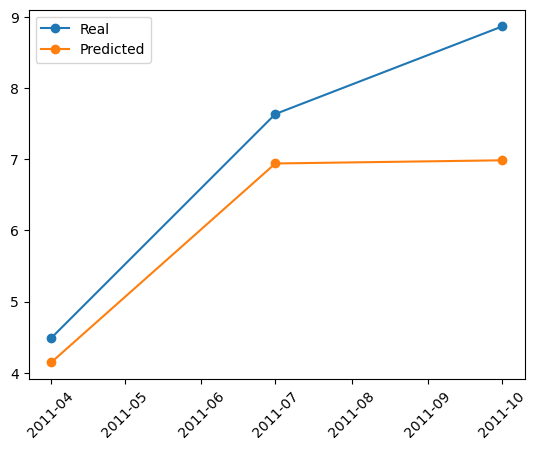

Реальный прирост за 2011 год: 22.43%
Прогнозный прирост за 2011 год: 19.15%

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.23,1.46,5.35
MSE,0.19,3.04,15.00
MAPE,18.12,21.94,0.21


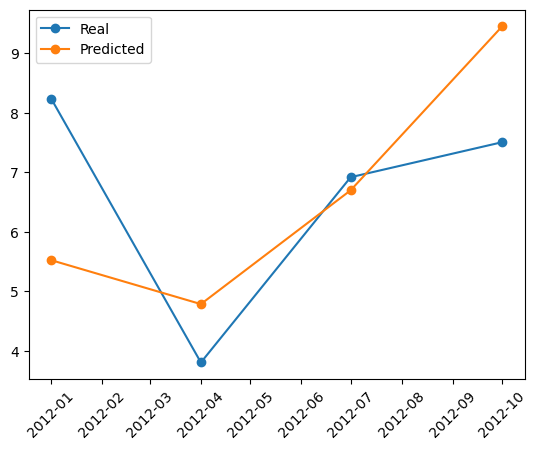

Реальный прирост за 2012 год: 29.15%
Прогнозный прирост за 2012 год: 29.14%

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.23,0.86,2.74
MSE,0.20,1.00,4.00
MAPE,14.06,17.16,0.22


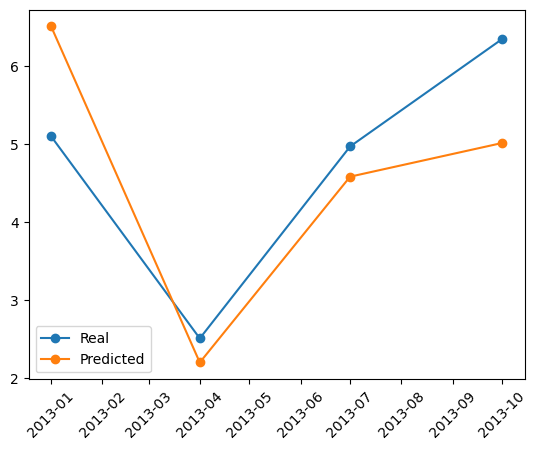

Реальный прирост за 2013 год: 20.28%
Прогнозный прирост за 2013 год: 19.56%

1/1 [==============================] - 0s 18ms/step


,Train,Test,Relative Difference
MAE,0.21,1.64,6.81
MSE,0.11,3.21,28.18
MAPE,14.92,53.35,2.58


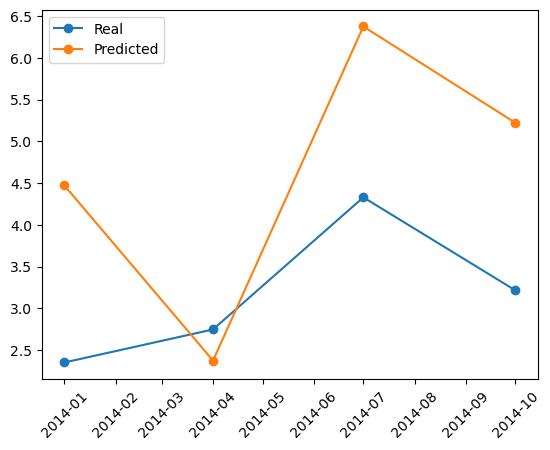

Реальный прирост за 2014 год: 13.25%
Прогнозный прирост за 2014 год: 19.71%

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.29,2.44,7.41
MSE,0.21,7.23,33.43
MAPE,16.78,560.15,32.38


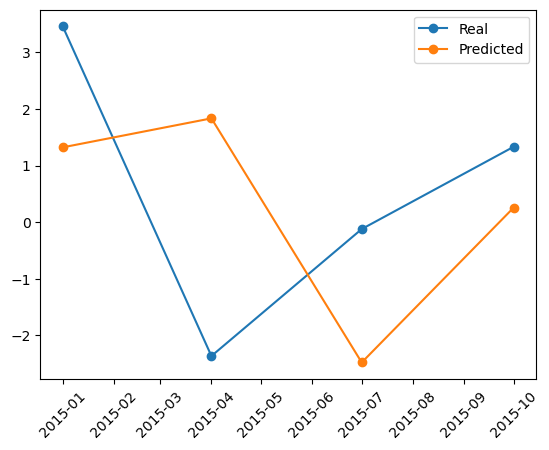

Реальный прирост за 2015 год: 2.23%
Прогнозный прирост за 2015 год: 0.88%

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.27,0.83,2.07
MSE,0.19,1.12,4.89
MAPE,9.64,469.64,47.72


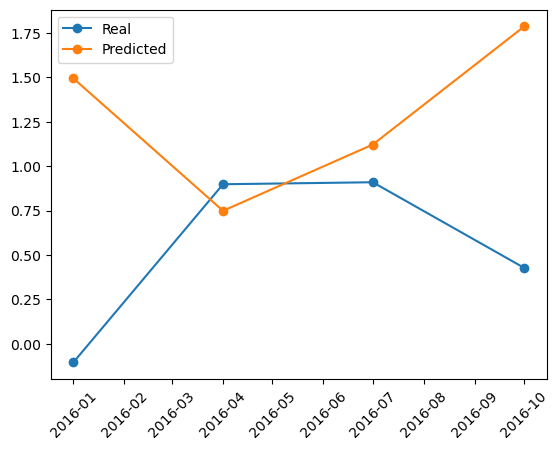

Реальный прирост за 2016 год: 2.14%
Прогнозный прирост за 2016 год: 5.25%

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.26,0.80,2.08
MSE,0.23,0.85,2.70
MAPE,9.20,48.66,4.29


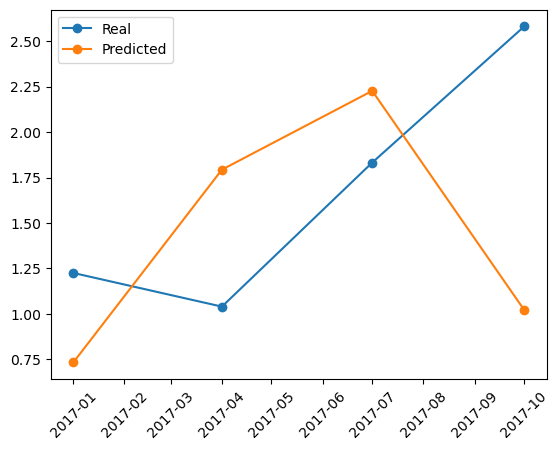

Реальный прирост за 2017 год: 6.84%
Прогнозный прирост за 2017 год: 5.89%

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.32,0.91,1.84
MSE,0.30,1.42,3.73
MAPE,17.07,26.40,0.55


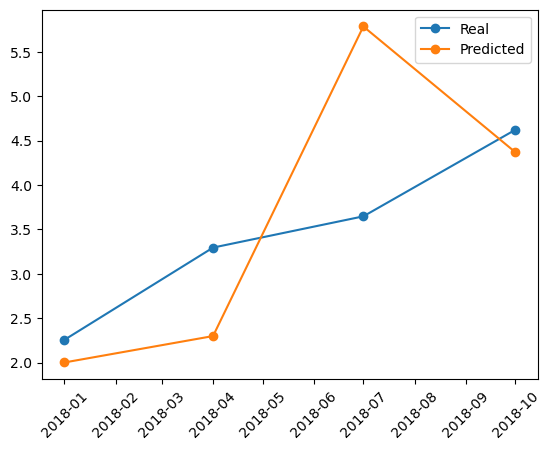

Реальный прирост за 2018 год: 14.54%
Прогнозный прирост за 2018 год: 15.21%

1/1 [==============================] - 0s 18ms/step


,Train,Test,Relative Difference
MAE,0.28,0.84,2.00
MSE,0.25,1.01,3.04
MAPE,14.54,26.51,0.82


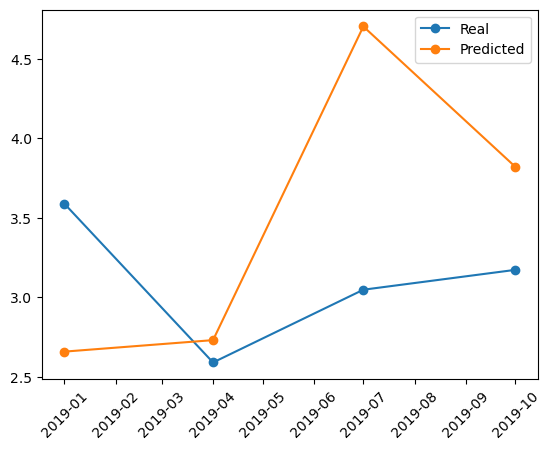

Реальный прирост за 2019 год: 12.99%
Прогнозный прирост за 2019 год: 14.65%

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.30,1.30,3.33
MSE,0.23,2.71,10.78
MAPE,15.67,62.66,3.00


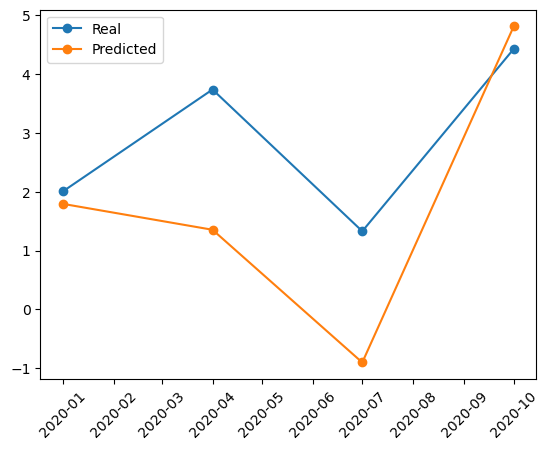

Реальный прирост за 2020 год: 11.97%
Прогнозный прирост за 2020 год: 7.16%

1/1 [==============================] - 0s 17ms/step


,Train,Test,Relative Difference
MAE,0.25,1.23,3.92
MSE,0.19,2.58,12.58
MAPE,11.99,37.89,2.16


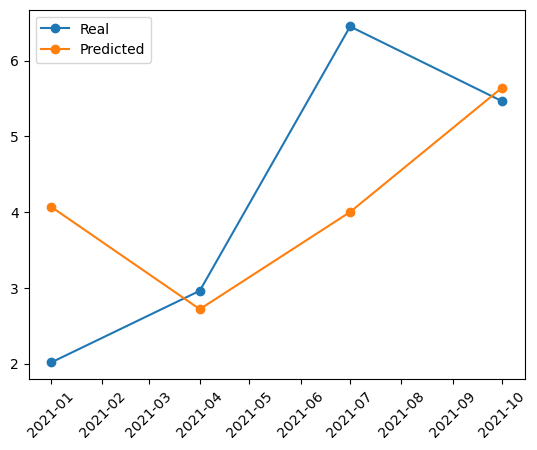

Реальный прирост за 2021 год: 17.92%
Прогнозный прирост за 2021 год: 17.45%

1/1 [==============================] - 0s 18ms/step


,Train,Test,Relative Difference
MAE,0.31,1.58,4.10
MSE,0.22,3.42,14.55
MAPE,18.70,59.09,2.16


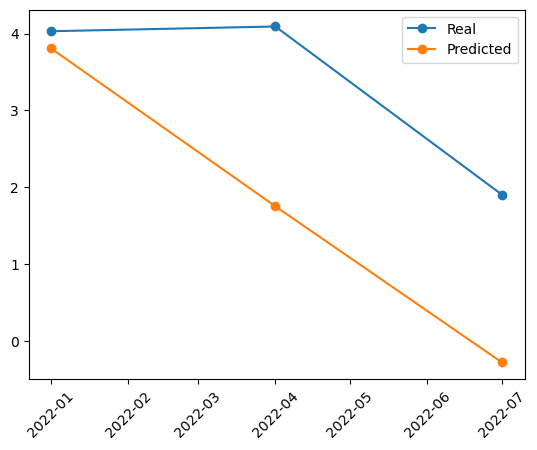

Реальный прирост за 2022 год: 10.35%
Прогнозный прирост за 2022 год: 5.33%

---------------------------------------------------------------------------
Средняя абсолютная ошибка по годовых прогнозам: 2.38%
Средняя относительная ошибка по годовых прогнозам: 32.92%
---------------------------------------------------------------------------
Медианная абсолютная ошибка по годовых прогнозам: 1.5%
Медианная относительная ошибка по годовых прогнозам: 14.23%
---------------------------------------------------------------------------


In [16]:
# Список признаков
feature_list_selected=['l1_target', 'l1_rkpdh_volume', 'gdp_volume', 'black_swan', 'cpi', 'vnok_volume', 'dotacii']
# Списки для заполнения
y_test_year_list=[]
y_test_pred_year_list=[]
quarter_pred_list=[]
# Прогоняем
for year in range(2011,2023):
    ## Выделяем train/test
    data_train=dataset_lr[(dataset_lr.period<f'{year}-01-01')|(dataset_lr.period>=f'{year}-12-31')]
    data_test=dataset_lr[(dataset_lr.period>=f'{year}-01-01')&(dataset_lr.period<f'{year}-12-31')]
    ## Выделяем X_train, X_test, y_train, y_test
    trainX, trainY = data_train[feature_list_selected], data_train['target']
    testX, testY =  data_test[feature_list_selected], data_test['target']
    trainX = np.reshape(trainX.values, (trainX.shape[0], 1,trainX.shape[1]))
    testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))
    ## Строим модель
    model = Sequential()
    model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2] )))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    history = model.fit(trainX, trainY, epochs=300, batch_size=8, validation_data=(testX, testY), verbose=0, shuffle=False)
    ## Строим прогнозы
    y_train_pred=model.predict(trainX)
    y_test_pred=model.predict(testX)
    ## Добавляем для отчёта
    for pred in y_test_pred:
        quarter_pred_list.append(pred[0])
    ## Смотрим качество
    display(regression_report(trainY,y_train_pred,testY,y_test_pred))
    ## Строим графики
    plt.plot(data_test.period,testY, label='Real',marker='o')
    plt.plot(data_test.period,y_test_pred, label='Predicted',marker='o')
    plt.xticks(rotation = 45)
    plt.legend()
    plt.show()
    ## Агрегируем реальные и прогнозные значения
    y_test_year=prod(100+testY)/(100**(len(testY)-1))
    y_test_pred_year=prod(100+y_test_pred)/(100**(len(y_test_pred)-1))
    ## Добавляем в списки
    y_test_year_list.append(y_test_year-100)
    y_test_pred_year_list.append(y_test_pred_year[0]-100)
    ## Выводим
    print(f'Реальный прирост за {year} год: {round((y_test_year-100),2)}%')
    print(f'Прогнозный прирост за {year} год: {round((y_test_pred_year[0]-100),2)}%\n')
# Считаем метрики
mae=round(mean_absolute_error(y_test_year_list,y_test_pred_year_list),2)
mape=round(mean_absolute_percentage_error(y_test_year_list,y_test_pred_year_list)*100,2)
medianae=round(median_absolute_error(y_test_year_list,y_test_pred_year_list),2)
medianape=round(median_absolute_percentage_error(y_test_year_list,y_test_pred_year_list)*100,2)
# Итог
print('---------------------------------------------------------------------------')
print(f'Средняя абсолютная ошибка по годовых прогнозам: {mae}%')
print(f'Средняя относительная ошибка по годовых прогнозам: {mape}%')
print('---------------------------------------------------------------------------')
print(f'Медианная абсолютная ошибка по годовых прогнозам: {medianae}%')
print(f'Медианная относительная ошибка по годовых прогнозам: {medianape}%')
print('---------------------------------------------------------------------------')
# Формируем отчёт
metric_df.loc[len(metric_df)] = ['Нейросеть после отбора признаков с дамми-переменными',
                                 mae,mape,medianae,medianape,date_now]
year_predictions['y_pred_nn_selected_dummy']=y_test_pred_year_list
quarter_predictions['y_pred_nn_selected_dummy']=quarter_pred_list

### Сохраняем отчёты в эксель

In [17]:
year_predictions.to_excel('Годовые прогнозы.xlsx',index=0)
quarter_predictions.to_excel('Квартальные прогнозы.xlsx',index=0)
metric_df.to_excel('Метрики по годам.xlsx',index=0)